<a href="https://colab.research.google.com/github/rifqoi/BERT-Sentiment-Analysis/blob/main/10-indobert-base-p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword.txt
!wget https://cdn.discordapp.com/attachments/818681954303868938/994060411366281216/2kdata.json

--2022-07-07 09:17:59--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv.1’

kamus_alay.csv.1    100%[===================>]  48.75K  --.-KB/s    in 0.007s  

2022-07-07 09:17:59 (7.25 MB/s) - ‘kamus_alay.csv.1’ saved [49923/49923]

--2022-07-07 09:17:59--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [3]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 9.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=6ec83629ffd798c888ac391c9c39b7d53ce7a07b9e1a97a97f6a114e8fe1a913
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.2 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 6.6 MB 51.2 MB/s 
     |████████████████████████████████| 596 kB 72.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
 

In [32]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
import string

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer
from transformers import InputExample, InputFeatures
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Import data
df = pd.read_json("2kdata.json")

In [6]:
df = df.sample(frac=1)

In [7]:
df = df[["tweets", "sentiment"]]
df

,tweets,sentiment
27,mengawasi proyek sumur resapan yg pembangunann...,Negative
1684,Itukan jelas belum ada perencanaan. Masih perl...,Negative
898,"Mungkin sesi jakarta, formula E nya pake VR, j...",Negative
1069,apa yang sehatkan dan pulihkan ekonomi Jakarta...,Positive
465,Prestasi paling menonjol adalah meresapkan ang...,Negative
...,...,...
1801,Gak jauh ada sirkuit Formula E.. makin keren ...,Positive
261,Jadi ngga sabar pengen nonton Formula E di Jak...,Positive
1160,Formula E.. Kemanfaatannya cm buat anies.. N...,Negative
1610,Formula E menjadi salah satu acara internasion...,Neutral


In [8]:
df.tweets = df.tweets.apply(lambda x: x.lower())
df

,tweets,sentiment
27,mengawasi proyek sumur resapan yg pembangunann...,Negative
1684,itukan jelas belum ada perencanaan. masih perl...,Negative
898,"mungkin sesi jakarta, formula e nya pake vr, j...",Negative
1069,apa yang sehatkan dan pulihkan ekonomi jakarta...,Positive
465,prestasi paling menonjol adalah meresapkan ang...,Negative
...,...,...
1801,gak jauh ada sirkuit formula e.. makin keren ...,Positive
261,jadi ngga sabar pengen nonton formula e di jak...,Positive
1160,formula e.. kemanfaatannya cm buat anies.. n...,Negative
1610,formula e menjadi salah satu acara internasion...,Neutral


In [ ]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.tweets)
  count += 1

4 tahun di jakarta cuma dpt stadion jis (cuma numpang nyelsein) dan formula e yg belum jelas blas...... makan tu gubernur seagama.... cukup jakarta aja yg dibohongin
harusnya tulisannya enjoy jakarta karena formula e sukses nama indonesia pasti terbawa juga, selama ini proses pengerjaan hingga pembangunan melalui jalan yg terjal dan curam cobaan demi cobaan dilalui hingga saat ini, tapi disayangkan kesannya projek ini hanya projek pemda dki.
nah loh belum ada progres apa"udah ada biaya tambahan ke kontraktor untuk bikin sirkkuit formula e ini adalah azab dari allah swt tidak merestui evert formula e untuk pemprov dki jakarta yang suka bohongin rakyatnya,dan juga mengatasnamakan pemulihan ekonomi rakyat dki jakarta.
s7 , tapi kasih tau dong, pembalap yg terkenal d formula e... soalnya kemarin jakarta antusias menyambut pembalap gp kayak marquez, daviouoso dll... gimana mau d tonton kalo pembalapnya ga ada yg kenal....😃😃😃😃
satu aja harapan dan doa saya, semoga tidak ada sabotase dari pih

In [9]:
def clean_data(x):
    x = x.lower()
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\\1 persen", x)
    # Mengubah emoji menjadi kata 
    x = emoji.demojize(x, delimiters=(" ", " ")) 
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang 
    x = re.sub(r'(.)\1+', r'\1\1', x)     
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)

    return x


In [10]:
string_example = "1%#FORMULAE #MANTAPJIWA @HeriYan20910746 @nobody26813 @michellejakbar tong kosonggggg!!😂 semua ada kontraknya, formula e itu kontrak 5 tahun, dan akan ada selama 5 tahun kedepan, dan bukan tidak mungkin akan ada ajang atau event lainnya, namanya juga jakarta, pusat indonesia, kemungkinan2 eo event2 lain untuk pakai pasti ada🙏👍👍👍 https://t.co/WP8jKb3wuW"

In [11]:
print(clean_data(string_example))

1 persen tong kosongg face_with_tears_of_joy semua ada kontraknya formula e itu kontrak 5 tahun dan akan ada selama 5 tahun kedepan dan bukan tidak mungkin akan ada ajang atau event lainnya namanya juga jakarta pusat indonesia kemungkinan2 eo event2 lain untuk pakai pasti ada folded_hands thumbs_up thumbs_up thumbs_up 


In [12]:
df_clean = df.copy()
df_clean['tweets'] = df.tweets.apply(clean_data)
df_clean.head()

,tweets,sentiment
27,mengawasi proyek sumur resapan yg pembangunann...,Negative
1684,itukan jelas belum ada perencanaan masih perlu...,Negative
898,mungkin sesi jakarta formula e nya pake vr jad...,Negative
1069,apa yang sehatkan dan pulihkan ekonomi jakarta...,Positive
465,prestasi paling menonjol adalah meresapkan ang...,Negative


In [13]:
df_tokenized = df.copy()
df_tokenized["tweets"] = df_clean.tweets.apply(word_tokenize)
df_tokenized

,tweets,sentiment
27,"[mengawasi, proyek, sumur, resapan, yg, pemban...",Negative
1684,"[itukan, jelas, belum, ada, perencanaan, masih...",Negative
898,"[mungkin, sesi, jakarta, formula, e, nya, pake...",Negative
1069,"[apa, yang, sehatkan, dan, pulihkan, ekonomi, ...",Positive
465,"[prestasi, paling, menonjol, adalah, meresapka...",Negative
...,...,...
1801,"[gak, jauh, ada, sirkuit, formula, e, makin, k...",Positive
261,"[jadi, ngga, sabar, pengen, nonton, formula, e...",Positive
1160,"[formula, e, kemanfaatannya, cm, buat, anies, ...",Negative
1610,"[formula, e, menjadi, salah, satu, acara, inte...",Neutral


In [47]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}

for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay wokwokw
custom_word = {
    "bong": "cebong",
    "bongg": "cebong",
    "cebi": "cebong",
    "cebii": "cebong",
    "drun": "kadrun",
    "drunn": "kadrun",
    "druunn": "kadrun",
    "gabener": "gubernur",
    "gabenerr": "gubernur",
    "goodbener": "gubernur",
    "goodbenerr": "gubernur",
    "gotbener": "gubernur",
    "gub": "gubernur",
    "gutbener": "gubernur",
    "gutbenerr": "gubernur",
    "even": "event",
    "komitmen":  "commitment",
    "komitmenn":  "commitment",
    "komitmeen":  "commitment",
    "commitmentt": "commitment",
    "committmeentt": "commitment",
    "ayoo": "ayo",
    "ayok": "ayo",
    "ayook": "ayo",
    "ayokk": "ayo",
    "ayookk": "ayo",
    "kuy": "ayo",
    "kuyy": "ayo",
    "knapa": "kenapa",
    "knapaa": "kenapa",
    "knp": "kenapa",
    "knpa": "kenapa",
    "knpaa": "kenapa",
    "enggak": "tidak",
    "enggakk": "tidak",
    "enggaak": "tidak",
    "enggaakk": "tidak",
    "gak": "tidak"

}

alay_word_dict.update(custom_word)

In [15]:
def normalize_text(x):
  # Ubah kata alay menjadi formal
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]
  return x

df_normalized = df_tokenized.copy()
df_normalized["tweets"] = df_normalized.tweets.apply(normalize_text)
df_normalized

,tweets,sentiment
27,"[mengawasi, proyek, sumur, resapan, yang, pemb...",Negative
1684,"[itukan, jelas, belum, ada, perencanaan, masih...",Negative
898,"[mungkin, sesi, jakarta, formula, e, nya, paka...",Negative
1069,"[apa, yang, sehatkan, dan, pulihkan, ekonomi, ...",Positive
465,"[prestasi, paling, menonjol, adalah, meresapka...",Negative
...,...,...
1801,"[enggak, jauh, ada, sirkuit, formula, e, makin...",Positive
261,"[jadi, enggak, sabar, pengin, menonton, formul...",Positive
1160,"[formula, e, kemanfaatannya, cuma, buat, anies...",Negative
1610,"[formula, e, menjadi, salah, satu, acara, inte...",Neutral


In [51]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak', 'jangan', 'bukan']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar', 'makin']
other_words = ["hari", "jauh"]
stopwords_to_remove = [negation_words, strong_words, other_words]

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

df_stripped_stopwords = df_normalized.copy()
df_stripped_stopwords["tweets"] = df_stripped_stopwords.tweets.apply(remove_stopwords)
df_stripped_stopwords

,tweets,sentiment
27,"[mengawasi, proyek, sumur, resapan, pembanguna...",Negative
1684,"[itukan, perencanaan, didalami, transfer, form...",Negative
898,"[sesi, jakarta, formula, e, nya, pakai, vr, pe...",Negative
1069,"[sehatkan, pulihkan, ekonomi, jakarta, formula...",Positive
465,"[prestasi, menonjol, meresapkan, anggaran, mem...",Negative
...,...,...
1801,"[enggak, jauh, sirkuit, formula, e, makin, ker...",Positive
261,"[enggak, sabar, pengin, menonton, formula, e, ...",Positive
1160,"[formula, e, kemanfaatannya, anies, nirmanfaat...",Negative
1610,"[formula, e, salah, acara, internasional, dige...",Neutral


In [ ]:
print(df.tweets[572])
print(df_clean.tweets[572])
print(df_tokenized.tweets[572])
print(' '.join(df_normalized.tweets[572]))
print(df_stripped_stopwords.tweets[572])

yg bisa dipangkas,lakukan!klo yg udh keburu jalan dan masuk kantong,lanjut🤣🤣🤣kayak formula e gimana itu, komitmen fee 500 milliar😆😆😆enjoy lah warga jakarta, gubernur nya oon
yg bisa dipangkas lakukan klo yg udh keburu jalan dan masuk kantong lanjut kayak formula e gimana itu komitmen fee 500 milliar enjoy lah warga jakarta gubernur nya oon
['yg', 'bisa', 'dipangkas', 'lakukan', 'klo', 'yg', 'udh', 'keburu', 'jalan', 'dan', 'masuk', 'kantong', 'lanjut', 'kayak', 'formula', 'e', 'gimana', 'itu', 'komitmen', 'fee', '500', 'milliar', 'enjoy', 'lah', 'warga', 'jakarta', 'gubernur', 'nya', 'oon']
yang bisa dipangkas lakukan kalau yang sudah keburu jalan dan masuk kantong lanjut kayak formula e bagaimana itu commitment fee 500 milliar enjoy lah warga jakarta gubernur nya oon
['dipangkas', 'lakukan', 'keburu', 'jalan', 'masuk', 'kantong', 'kayak', 'formula', 'e', 'commitment', 'fee', '500', 'milliar', 'enjoy', 'warga', 'jakarta', 'gubernur', 'nya', 'oon']


In [ ]:
print(df.tweets[570])
print(df_normalized.tweets[570])
print(' '.join(remove_stopwords(df_tokenized.tweets[570])))

tak peduli warga nyemplung dan mati di sungai tak peduli minyak goreng langka di jakarta tak peduli jakarta kebanjiran tak peduli kasus covid melonjak di jkt  maaf...sy sibuk ngurusin formula e yg akan melambungkan nama saya utk pilpres.  ttd teroris ayat dan mayat
['tak', 'peduli', 'warga', 'nyemplung', 'dan', 'mati', 'di', 'sungai', 'tak', 'peduli', 'minyak', 'goreng', 'langka', 'di', 'jakarta', 'tak', 'peduli', 'jakarta', 'kebanjiran', 'tak', 'peduli', 'kasus', 'covid', 'melonjak', 'di', 'jakarta', 'maaf', 'saya', 'sibuk', 'mengurusi', 'formula', 'e', 'yang', 'akan', 'melambungkan', 'nama', 'saya', 'untuk', 'pilpres', 'ttd', 'teroris', 'ayat', 'dan', 'mayat']
tak peduli warga nyemplung mati sungai tak peduli minyak goreng langka jakarta tak peduli jakarta kebanjiran tak peduli covid melonjak jkt maaf sy sibuk ngurusin formula e yg melambungkan nama utk pilpres ttd teroris ayat mayat


In [17]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("mengembalikan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

# df_stemmed = df_stripped_stopwords.copy()
# df_stemmed["tweets"] = df_stemmed.tweets.apply(stemming_text)
# df_stemmed

In [ ]:
df_stemmed.tweets = df_stemmed.tweets.apply(lambda x: ' '.join(x))
df_stemmed.tweets

476     bamsoet mending fokus urus motogp mandalika ur...
432     ya bandingin harga tiket ya negara duit enggak...
1504    ayook anies kalah helat formula e sukses amp t...
739     knapa gerah jakarta sirkuit sbagai ajang balap...
1190    kerja proyek sirkuit formula e jakarta target ...
                              ...                        
944     urus g20indonesia biar urus presiden bantu bel...
928                cebong menang tonton formula e jakarta
422     lokasi formula e selenggara jakarta jawa barat...
1915    63 hari mnjelang formula e jakarta boro-boro b...
1912    ah bacod doang lu momentum baik kampanye mobil...
Name: tweets, Length: 2022, dtype: object

In [52]:
def preprocess_data(df, stem=False):
  df_processed = df.copy()
  df_processed.tweets = df_processed.tweets.apply(clean_data)
  df_processed.tweets = df_processed.tweets.apply(word_tokenize)
  df_processed.tweets = df_processed.tweets.apply(normalize_text)
  df_processed.tweets = df_processed.tweets.apply(remove_stopwords)
  if stem:
    df_processed.tweets = df_processed.tweets.apply(stemming_text)
  df_processed.tweets = df_processed.tweets.apply(lambda x: ' '.join(x))
  df_processed.sentiment = df_processed.sentiment.map({
    "Positive": 0,
    "Neutral": 1,
    "Negative": 2,
  })
  return df_processed

df_preprocessed = preprocess_data(df)
df_preprocessed

,tweets,sentiment
27,mengawasi proyek sumur resapan pembangunannya ...,2
1684,itukan perencanaan didalami transfer formula e...,2
898,sesi jakarta formula e nya pakai vr pembalapny...,2
1069,sehatkan pulihkan ekonomi jakarta formula e,0
465,prestasi menonjol meresapkan anggaran membeli ...,2
...,...,...
1801,tidak jauh sirkuit formula e makin keren jakar...,0
261,enggak sabar pengin menonton formula e jakarta...,0
1160,formula e kemanfaatannya anies nirmanfaat masy...,2
1610,formula e salah acara internasional digelar ja...,1


In [49]:
df.tweets[1801]

'gak jauh ada sirkuit formula e..  makin keren jakarta sebagai salah satu kota ramah lingkungan'

In [53]:
def make_corpus(column):
    
    text_body = ""


    for sentences in column:
      sentences = sentences.split(' ')
      text_body += ' ' +' '.join(sentences)

    print(text_body)
    # transform list of words into 1 body of text
    corpus = re.sub('[ ]+',' ', text_body) # replace double whitespace with one
        
    return corpus

In [54]:
# Takes a while
corpus = make_corpus(df_preprocessed.tweets)

 mengawasi proyek sumur resapan pembangunannya asalan dana formula e gila gilaan membangun jakarta itukan perencanaan didalami transfer formula e jakarta jauh mahal kota negara curiga kongkalikong asing grinning_face_with_sweat face_with_tears_of_joy rolling_on_the_floor_laughing sesi jakarta formula e nya pakai vr pembalapnya rumah pakai ps5 track rahasia nunggu gabenernya mengolah lintasan sehatkan pulihkan ekonomi jakarta formula e prestasi menonjol meresapkan anggaran membeli piagam penghargaan menendang pohon laporan hasilnya kemanakan amp meresapkan anggaran formula e amp tidak lupa kolam renang terbesar asia warga dki jakarta korbannya squinting_face_with_tongue tiket formula e usula point nya stadium jis nyata bukan kaya mobil esemka enggak kayak kereta cepat jakarta tidak bandung warga jakarta bab tak jamban pemprov dki jakarta hamburkan duit rp 560 formula e hematnya dimana sirkuit formula e kejar tayang disaat bersamaan jakarta guyur hujan selesai sesuai tenggat program bagu

In [55]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 6267


In [56]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [57]:
corpus_freq = word_freq(corpus, top=20)

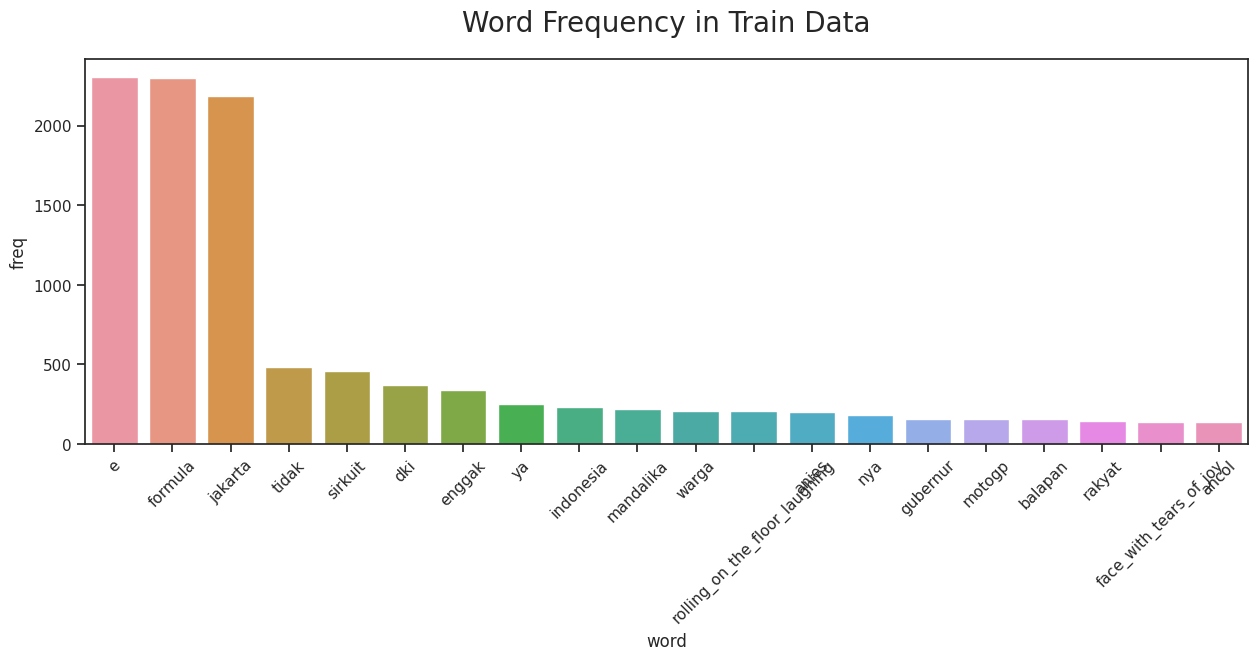

In [58]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

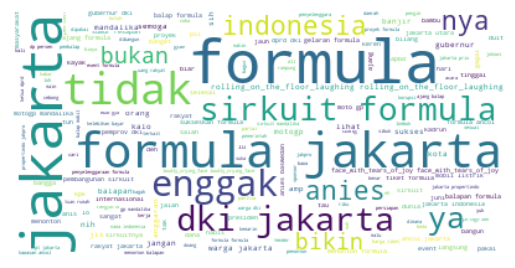

In [59]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [60]:
# train val split
train_set, val_set = train_test_split(df_preprocessed, test_size=0.3, stratify=df_preprocessed.sentiment)
# val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment, random_state=1)

In [24]:
def convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN, test=None): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  if test is not None:
    test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                            text_a = x[DATA_COLUMN], 
                                                            text_b = None,
                                                            label = x[LABEL_COLUMN]), axis = 1)
    return train_InputExamples, validation_InputExamples, test_InputExamples

  return train_InputExamples, validation_InputExamples


In [25]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [80]:
def convert_data_to_tf_dataset(train, val, data_column, label_column, tokenizer, test=False):
  if test:
    train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(train_set, val_set,  data_column, label_column, test=True)
    
    train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
    train_data = train_data.shuffle(100).batch(32).repeat(2)
    
    validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
    validation_data = validation_data.batch(32)
  
    test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
    test_data = test_data.batch(32)

    return train_data, validation_data, test_data

  train_InputExamples, validation_InputExamples, = convert_data_to_examples(train_set, val_set,  data_column, label_column,)
  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(100).batch(32).repeat(2)
  
  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(32)
  return train_data, validation_data


In [81]:
def bert_model(pretrained_model):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  config = BertConfig.from_pretrained(pretrained_model)
  config.labels = 3
  
  base_model = TFBertForSequenceClassification.from_pretrained(pretrained_model, config=config, )
  return base_model, tokenizer

model, tokenizer = bert_model('indobenchmark/indobert-base-p2')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'sentiment'

train_data, validation_data = convert_data_to_tf_dataset(train_set, val_set, DATA_COLUMN, LABEL_COLUMN, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [85]:
# model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config, )
# model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=4, validation_data=validation_data)

Epoch 1/4
90/90 [==============================] - 117s 919ms/step - loss: 0.8068 - accuracy: 0.6643 - val_loss: 0.7585 - val_accuracy: 0.6985
Epoch 2/4
90/90 [==============================] - 77s 850ms/step - loss: 0.3333 - accuracy: 0.8859 - val_loss: 0.8866 - val_accuracy: 0.7199
Epoch 3/4
90/90 [==============================] - 76s 843ms/step - loss: 0.0795 - accuracy: 0.9795 - val_loss: 1.2136 - val_accuracy: 0.6985
Epoch 4/4
90/90 [==============================] - 76s 845ms/step - loss: 0.0457 - accuracy: 0.9848 - val_loss: 1.2832 - val_accuracy: 0.7364


In [ ]:
evaluate = model.evaluate(test_data)
print('Loss of the model is - ', evaluate[0])
print('Accuracy of the model is - ', evaluate[1]*100, '%')

classes =  ["Positive", "Neutral", "Negative"]
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
# print('Confusion Matrix')
# conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
# df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
# ax = sns.heatmap(df_cm, annot=True, cmap='Blues')

# ax.set_title('Seaborn Confusion Matrix with labels\n\n')
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ')

7/7 [==============================] - 2s 298ms/step - loss: 1.5066 - accuracy: 0.7463
Loss of the model is -  1.5066324472427368
Accuracy of the model is -  74.6268630027771 %


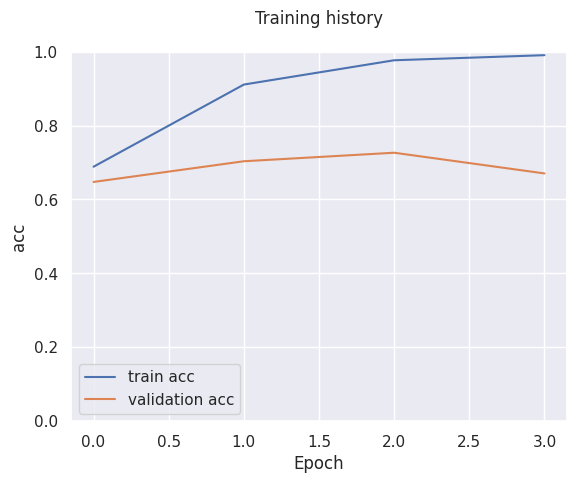

In [ ]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Overfit parah owkwokw

In [ ]:
test_sentences = list(test_set["tweets"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(test_sentences)):
  print(test_sentences[i], ": ", labels[label[i]])

ValueError: ignored

In [ ]:
list(test_set["tweets"])

['Yth pak  , gelaran Moto3, moto2 &amp; MotoGP telah sukses digelar... Coba bapak berpikir jernih, untuk event Formula E yang akan digelar di Jakarta dipindah ke Mandalika pak. Karena sampai saat ini gak jelas juntrungannya, sampai kapan sirkuit formula E nya jadi...🙏',
 'dipikir formula e itu badan usaha milik dki jakarta apa ya',
 'Formula E buat taun depan, di jakarta, pasti lbh mahal lg tuh 🤭.  Tapi ya, kalo ga jadi lg mah atuh malu gubernur  nya wkwkwk',
 'Padahal pemerintah juga mendorong Formula E, FE atau MotoGP sama-sama nguntungin buat Indonesia itu sendiri padahal, jadi kontroversi karena diadain di Jakarta aja dan Gubernurnya pak Anies.',
 'Selesai saja belum....selesaikan dan laksanakan saja Formula E itu....daripada ditangkap KPK. Uang orang Jakarta sdh nggak jelas kemana....',
 'Saya mengharapkan event formula E jakarta juga sukses sbgmn event motogp mandalika. Pasti semua ada plus minusnya dalam penyelenggaraan, apalagi semua event perdana. Mudah2 kedepan semakin sukses